In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_v0_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset_v0/', output=dir_path, ratio=(0.8, 0.2))

Copying files: 6101 files [00:00, 13766.01 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4879 images belonging to 4 classes.
Found 1222 images belonging to 4 classes.


## View some data

In [5]:
num_classes = 4

model = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           264       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [8]:
epochs=150
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/150
77/77 [==============================] - 2s 12ms/step - loss: 1.4415 - accuracy: 0.2730 - val_loss: 1.4268 - val_accuracy: 0.2684
Epoch 2/150
77/77 [==============================] - 1s 9ms/step - loss: 1.4132 - accuracy: 0.2900 - val_loss: 1.3939 - val_accuracy: 0.3175
Epoch 3/150
77/77 [==============================] - 1s 10ms/step - loss: 1.3619 - accuracy: 0.3644 - val_loss: 1.3291 - val_accuracy: 0.3920
Epoch 4/150
77/77 [==============================] - 1s 10ms/step - loss: 1.3153 - accuracy: 0.4052 - val_loss: 1.3014 - val_accuracy: 0.4133
Epoch 5/150
77/77 [==============================] - 1s 10ms/step - loss: 1.2976 - accuracy: 0.4193 - val_loss: 1.2912 - val_accuracy: 0.4296
Epoch 6/150
77/77 [==============================] - 1s 10ms/step - loss: 1.2857 - accuracy: 0.4230 - val_loss: 1.2780 - val_accuracy: 0.4116
Epoch 7/150
77/77 [==============================] - 1s 10ms/step - loss: 1.2781 - accuracy: 0.4290 - val_loss: 1.2728 - val_accuracy: 0.4313
Epoch 8

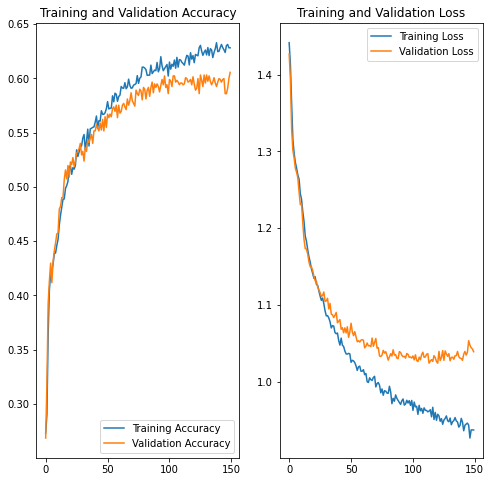

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

20/20 [==============================] - 0s 7ms/step - loss: 1.0391 - accuracy: 0.6056
Test accuracy : 0.6055646538734436


In [11]:
# Save the weights model.
model.save('./data/humanModel/model_v0.h5')

In [12]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [13]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [14]:
path = "./data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png'